In [1]:
#libraries
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import time
import sklearn
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 

%matplotlib inline

print('done')


done


In [2]:
#loading images
cars=[]
notcars=[]
vehicle_images=glob.glob("vehicles/**/*.png")
for image in vehicle_images:
    #images=cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    cars.append(image)
nonvehicle_images=glob.glob("non-vehicles/**/*.png")
for image in nonvehicle_images:
    #images=cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    notcars.append(image)
print("Training Images Read")
print(len(cars))
print(len(notcars))

Training Images Read
8792
8968


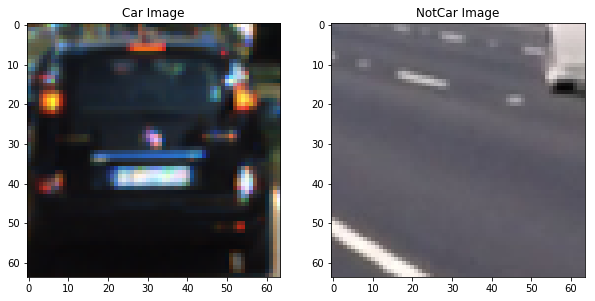

In [3]:
#visusalizing the sample images
import random
ind = np.random.randint(0, len(cars))
image1 = mpimg.imread(cars[ind])
indN = np.random.randint(0, len(notcars))
image2=mpimg.imread(notcars[indN])

fig=plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Car Image')
plt.imshow(image1)
plt.subplot(122)
plt.title('NotCar Image')
plt.imshow(image2)



In [4]:
#function to extract HOG
#duplicated from the lesson
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,visualise= vis, feature_vector= feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,visualise= vis, feature_vector= feature_vec)
        return features
print("Done")


Done


C:\Users\svelusa\Documents\Conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


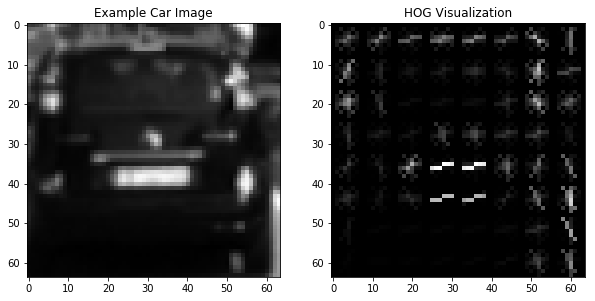

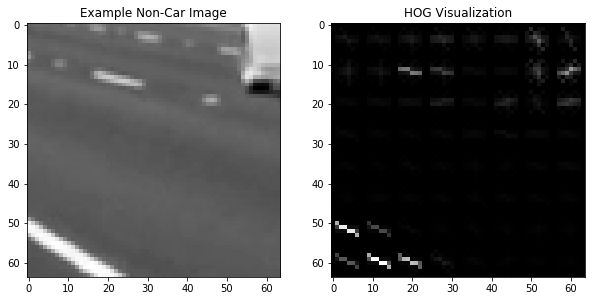

In [5]:
# Generate a random index to look at a car image
car_img = image1
gray = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

#for non-car images
Notcar_img = image2
gray = cv2.cvtColor(Notcar_img, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [6]:
#explore spatial binning
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
print("Done")

Done


In [7]:
#color channels
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features
print("Done")

Done


In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
print("Done")

Done


In [9]:
# Declare All Constants/ Parameters
# Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

print("Done")

Done


In [10]:
t1 = time.time()
print("Extracting car features")
car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
print("Extracting non-car features")
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2 - t1, 2), 'seconds to extract the features.')
print("Done")

Extracting car features


C:\Users\svelusa\Documents\Conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Extracting non-car features
444.74 seconds to extract the features.
Done


In [11]:
#defind feature vector
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# preprocessing of feature - Zero mean and unit norm

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
# Training:

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the accuracy of the learned classifier
t1=time.time()
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t2=time.time()
print(round((t2-t1)/len(X_test), ), 'seconds to test SVC...')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
30.84 Seconds to train SVC...
Test Accuracy of SVC =  0.9913
0 seconds to test SVC...


In [12]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
print("Done")

Done


In [13]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
print("Done")

Done


In [14]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):   
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)

    hot_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return hot_windows
print("Done")

Done


In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap # Iterate through list of bboxes
print("Done")

Done


In [16]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
print("Done")

Done


In [17]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img
print("Done")

Done


In [18]:
def single_image_pipeline(image):

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    box_image = np.copy(image)
    hot_windows_current_frame = []
    
    scales       = [0.88, 1.60, 3.50]
    y_pos_start  = [420, 400, 380]
    y_pos_stop    = [510, 560, 660]

    for i in range(len(scales)):
        hot_windows = find_cars(image, y_pos_start[i], y_pos_stop[i], scales[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_image = draw_boxes(box_image, hot_windows, color = (0, 255, 0), thick = 4)
        hot_windows_current_frame = hot_windows_current_frame + hot_windows
    
    #cv2.imwrite("boxed_image.jpg",box_image)
   # plt.imshow(box_image)
    
    heat_threshold = 1 
            
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows_current_frame)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    vehicle_detected= draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure(figsize=(12,10))
    plt.subplot(131)
    plt.imshow(vehicle_detected)
    plt.title('Car Positions')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(133)
    plt.imshow(box_image)
    plt.title('box_image')
    fig.tight_layout()
    plt.show()
    
    
    
    return vehicle_detected
print("done")

done


C:\Users\svelusa\Documents\Conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


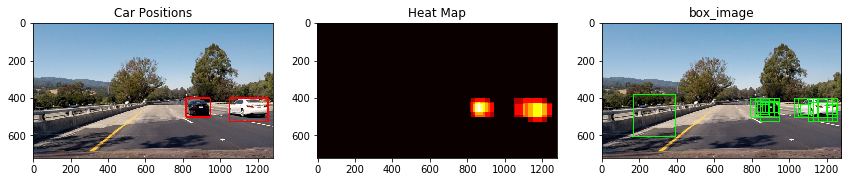

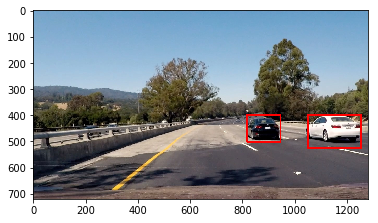

In [19]:
# Test on a single image

image = mpimg.imread('test_images/test4.jpg')
single_img_result = single_image_pipeline(image)
plt.imshow(single_img_result)
#cv2.imwrite("result_01_multi_win.jpg", single_img_result)

C:\Users\svelusa\Documents\Conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


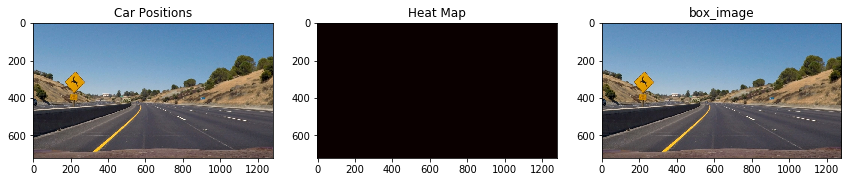

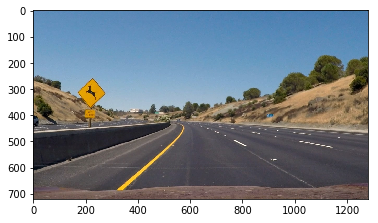

In [20]:
image = mpimg.imread('test_images/test2.jpg')
single_img_result = single_image_pipeline(image)
plt.imshow(single_img_result)

In [21]:
def process_image(image):

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    box_image = np.copy(image)
    hot_windows_current_frame = []
    
    scales       = [0.88, 1.60, 3.50]
    y_pos_start  = [420, 400, 380]
    y_pos_stop    = [510, 560, 660]

    for i in range(len(scales)):
        hot_windows = find_cars(image, y_pos_start[i], y_pos_stop[i], scales[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_image = draw_boxes(box_image, hot_windows, color = (0, 255, 0), thick = 4)
        hot_windows_current_frame = hot_windows_current_frame + hot_windows

    # Average single image detection results from last few frames        
    global hot_windows_prev
    avg_last_frames = 10
    heat_threshold = 10 

    hot_windows_prev.append(hot_windows_current_frame)

    avg_hot_windows = [] 
    
    if(len(hot_windows_prev) > avg_last_frames):
        for cnt in range(1, avg_last_frames+1):
            for windows in hot_windows_prev[-cnt]:
                avg_hot_windows.append(windows)
            
    # Add heat to each box in box list
    heat = add_heat(heat, avg_hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    vehicle_detected = draw_labeled_bboxes(np.copy(image), labels)

    return vehicle_detected
print("Done")

Done


In [22]:
# Global variable to store hot window results of last 
hot_windows_prev= []

from moviepy.editor import VideoFileClip
from IPython.display import HTML
-
video_output = 'project_video_out.mp4'
video_input  = VideoFileClip('project_video.mp4')
#video_input  = VideoFileClip('clip.mp4')
video_clip = video_input.fl_image(process_image)
video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [29:49<00:01,  1.45s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

